In [59]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import time
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import multilabel_confusion_matrix, matthews_corrcoef
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Flatten
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import os
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings("ignore")

In [60]:
num = random.randint(0, 9)
print(num)
random.seed(num)
seed = int(random.SystemRandom().random() * 100)
print(seed)
random.seed(seed)
seed = int(random.SystemRandom().random() * 100)
random.seed(seed)
print(seed)

0
16
20


In [61]:
def visualization(name,h,color,modelname):
  t = h.history[name]
  my_max = max(t)
  my_min = min(t)
  print(f'Name : {name} max : {my_max} min : {my_min}')
  plt.plot(t,color=color,linewidth=3.0)
  plt.title(name)
  plt.ylabel(name)
  plt.xlabel('Epoch')
  plt.legend([name],loc='upper left')
  plt.savefig(f'Results/LSTM-{modelname}-{name}.png')
  plt.show()

In [62]:
# Load data from dataframe
df = pd.read_csv('All.csv')
df = df.dropna()
x = df['review'].values
y = df['sentiment-Hand'].values

# Tokenize the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
x = tokenizer.texts_to_sequences(x)

vocab_size = len(tokenizer.word_index) + 1

# Pad the reviews
max_length = max([len(t) for t in x])

my_list = {
    "Anxiety","Post Traumatic Stress Disorde","Bipolar Disorde","Depression","Schizophrenia","Binge Eating Disorde","Anorexia","Bulimia","Aggressive Behavi",
    "Major Depressive Disorde","Neurosis","Autism","Obsessive Compulsive Disorde","Borderline Personality Disorde","Severe Mood Dysregulation",
    "Mania","Trichotillomania","Panic Disorde","Psychosis","Dissociative Identity Disorde","ADHD","Agitated State","Agitation","Anxiety and Stress",
    "Anorexia/Feeding Problems","Neurotic Depression","Persistent Depressive Disorde","Postpartum Depression","Generalized Anxiety Disorde",
    "Performance Anxiety","mance Anxiety","Social Anxiety Disorde","ICU Agitation","Schizoaffective Disorde"
}

In [63]:
# df = df[(df['condition'].isin(my_list) == False)]
x = df['review'].values
y = df['sentiment-Hand'].values
y_use,y_nuse,x_use, x_nuse  = train_test_split(y,x, test_size=0.95, random_state=seed, shuffle=True)
tokenizer.fit_on_texts(x_use)
x_seq = tokenizer.texts_to_sequences(x_use)

# Pad sequences to a fixed length
x_padded = pad_sequences(x_seq, maxlen=1000,)

# Compute the class weights
class_weights = class_weight.compute_class_weight(                                        
                                class_weight = "balanced",
                                classes = np.unique(y),
                                y = y)

# Create a dictionary of class weights
class_weight_dict = dict(enumerate(class_weights))

In [64]:
le = LabelEncoder()
y_use = le.fit_transform(y_use)

In [65]:
print(max_length)

1992


In [66]:
y_train,y_test,x_train, x_test  = train_test_split(y_use,x_padded, test_size=0.2, random_state=seed, shuffle=True)
print(f'Total:{(y.shape[0]/y.shape[0])*100},Train:{(y_train.shape[0]/y.shape[0])*100},Test:{(y_test.shape[0]/y.shape[0])*100}')

Total:100.0,Train:3.999644642281022,Test:1.000144948543267


In [67]:
print(f'Y:Train:{y_train.shape[0]},Test:{y_test.shape[0]}')
print(f'X:Train:{x_train.shape[0]},Test:{x_test.shape[0]}')

Y:Train:8554,Test:2139
X:Train:8554,Test:2139


In [68]:
# Define the fitness function
best_fitness = float("-inf")
best_model = None
best_generation = -1
best_fitness_list = []
best_model_list = []

In [69]:
# Define the search space
search_space = [(32, 128), # embedding size
                (1, 4), # number of neurons in the first hidden layer
                (1, 8), # number of neurons in the second hidden layer
                (0.0001, 0.1), # learning rate
                (32, 256), # batch size
                (1, 20)] # number of epochs

# Define the population size and number of generations
pop_size = 6
num_generations = 3

In [70]:
# Define the fitness function
def fitness(params,generation):
    global best_fitness, best_model, best_generation

    # Define model architecture
    inputs = Input(shape=(1000,))
    x = Embedding(vocab_size, int(params[0]))(inputs)
    x = Bidirectional(LSTM(int(params[1]), return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Bidirectional(LSTM(int(params[2])))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs, outputs)

    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Set early stopping monitor so the model stops training when it won't improve anymore
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=0, 
                                            factor=0.5, 
                                            min_lr=1e-25)
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)
    
    # Set up model checkpoint to save the best model based on validation accuracy
    filepath = f"Results/acc_model_gen.h5"
    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_accuracy',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='max')

    # Train the model
    history = model.fit(x_train, y_train, batch_size=int(params[4]), epochs=int(params[5]), validation_split=0.1,
                    callbacks=[learning_rate_reduction, es, checkpoint], class_weight=class_weight_dict, verbose=1)
    
    # Load best model
    model = load_model(filepath)

    # Evaluate the model on test data
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    fitness_value = accuracy

    # Save the model to a file
    model.save('Results/model.h5')

    # Update the best model and fitness value
    if fitness_value > best_fitness:
        best_fitness = fitness_value
        best_model = model
        best_generation = generation

    best_fitness_list.append(best_fitness)
    best_model_list.append(best_model)

    # Print the fitness value and parameters
    print("Generation:", generation, "Fitness:", fitness_value, "Best Fitness:", best_fitness, "Params:", params)

    return fitness_value

In [71]:
def genetic():

    best_fitness = -float('inf')
    best_model = None

    # Initialize the population
    population = []
    for i in range(pop_size):
        params = []
        for space in search_space:
            params.append(random.uniform(space[0], space[1]))
        population.append(params)

    # Initialize lists to store best fitness scores
    best_fitness_scores_history = []
    times = []
    start_time = time.time()

    # Iterate over generations
    for gen in range(num_generations):

        print(f'Generation {gen + 1}')

        # Evaluate fitness of each individual in the population
        fitness_scores = []
        for individual in population:
            fitness_scores.append(fitness(individual,{gen + 1}))

        # Normalize fitness scores
        sum_fitness = np.sum(fitness_scores)
        fitness_probs = [score/sum_fitness for score in fitness_scores]

        # Select parents for reproduction
        parents = []
        for i in range((pop_size // 2)):
            idx1 = np.random.choice(range(pop_size), size=1, p=fitness_probs)[0]
            idx2 = np.random.choice(range(pop_size), size=1, p=fitness_probs)[0]
            parents.append((population[idx1], population[idx2]))

        # Reproduce new offspring
        offspring = []

        for parent1, parent2 in parents:

            child1, child2 = [], []

            for i in range(len(parent1)):
                if random.random() < 0.5:
                    child1.append(parent1[i])
                    child2.append(parent2[i])
                else:
                    child1.append(parent2[i])
                    child2.append(parent1[i])
                
            offspring.append(child1)
            offspring.append(child2)
        
        # Mutate some of the offspring
        for i in range(len(offspring)):
            for j in range(len(offspring[i])):
                if random.random() < 0.5:
                    space = search_space[j]
                    offspring[i][j] = random.uniform(space[0], space[1])

        # Replace the old population with the new offspring
        population = offspring

        # Select the best individual as the result
        best_idx = np.argmax(fitness_scores)
        best_individual = population[best_idx]
        best_fitness_score = fitness_scores[best_idx]
        print('Best individual:', best_individual)
        print(f'Best fitness score in generation {gen + 1}: {best_fitness_score}')

        # Update best model if the current model is better
        if best_fitness_score > best_fitness:
            best_fitness = best_fitness_score
            best_model = load_model('Results/model.h5')
            best_model.save('Results/best_model.h5')
            print('Best model saved')

        # Append best fitness score to history lists
        best_fitness_scores_history.append(best_fitness_score)
        times.append(time.time() - start_time)

        print(f'Time : {time.time() - start_time}')
        start_time = time.time()

    # Plot best fitness scores over time
    plt.figure(figsize=(8, 6))
    plt.plot(best_fitness_scores_history, label='Best Fitness Scores')
    plt.scatter(np.argmax(best_fitness_scores_history), np.max(best_fitness_scores_history), color='red', label='Max Fitness Score')
    plt.scatter(np.argmin(best_fitness_scores_history), np.min(best_fitness_scores_history), color='green', label='Min Fitness Score')
    plt.plot(np.ones(num_generations) * np.mean(best_fitness_scores_history), label='Mean Fitness Score')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score')
    plt.title('Best Fitness Scores over Generation')
    plt.legend()
    plt.savefig('Results/Best_Fitness_Scores_over_Generation.png')
    plt.show()

    # Plot generations and time
    plt.figure(figsize=(8, 6))
    plt.plot(times, label='Time (s)')
    plt.scatter(np.argmax(times), np.max(times), color='red', label='Max Time')
    plt.scatter(np.argmin(times), np.min(times), color='green', label='Min Time')
    plt.plot(np.ones(num_generations) * np.mean(times), label='Mean Time')
    plt.xlabel('Generation')
    plt.ylabel('Time (s)')
    plt.title('Generations and Time')
    plt.legend()
    plt.savefig('Results/Generations_and_Time.png')
    plt.show()

    # Save the best model to a file
    best_model.save('Results/best_model.h5')

Generation 1
Epoch 1/13
86/86 [==============================] - 241s 3s/step - loss: 1.0990 - accuracy: 0.3613 - val_loss: 1.0643 - val_accuracy: 0.5164 - lr: 0.0010
Epoch 2/13
86/86 [==============================] - 233s 3s/step - loss: 1.0096 - accuracy: 0.4574 - val_loss: 0.9666 - val_accuracy: 0.6507 - lr: 0.0010
Epoch 3/13
86/86 [==============================] - 234s 3s/step - loss: 0.8975 - accuracy: 0.5687 - val_loss: 0.9731 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 4/13
86/86 [==============================] - 232s 3s/step - loss: 0.8262 - accuracy: 0.5295 - val_loss: 1.0287 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 5/13
86/86 [==============================] - 232s 3s/step - loss: 0.7731 - accuracy: 0.4977 - val_loss: 1.0860 - val_accuracy: 0.2430 - lr: 0.0010
Epoch 6/13
86/86 [==============================] - 237s 3s/step - loss: 0.7077 - accuracy: 0.5360 - val_loss: 1.0961 - val_accuracy: 0.2932 - lr: 5.0000e-04
Epoch 7/13
67/67 [==============================] - 15s 185

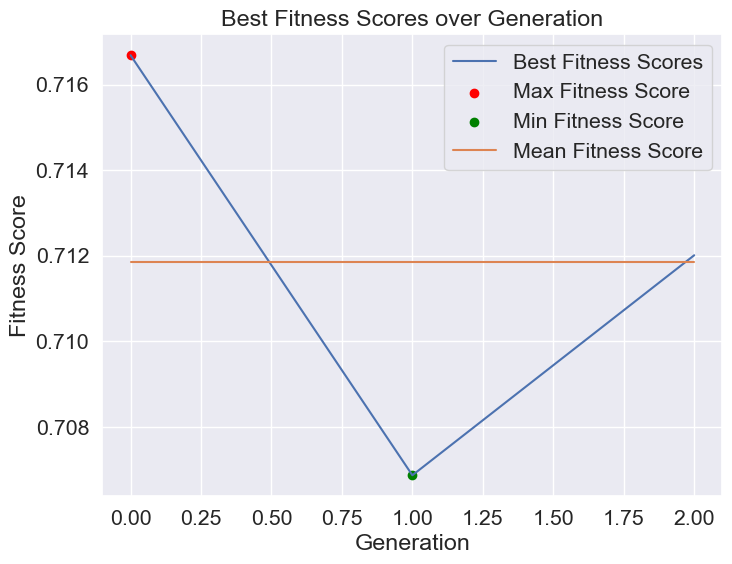

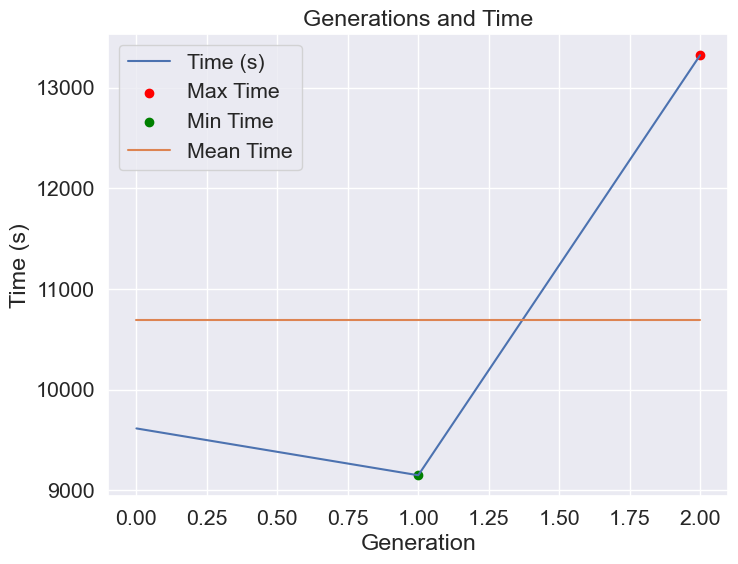

In [72]:
genetic()

In [73]:
# # plot best fitness over generations
# plt.plot(best_fitness_list)
# plt.title('Fitness over Po')
# plt.xlabel('Generation')
# plt.ylabel('Fitness')

# # plot max, min, and mean lines
# max_fitness = np.max(best_fitness_list)
# min_fitness = np.min(best_fitness_list)
# mean_fitness = np.mean(best_fitness_list)

# plt.axhline(mean_fitness, color='orange', linestyle='--', label='Mean')
# plt.plot(np.argmax(best_fitness_list), max_fitness, 'ro', label='Max')
# plt.plot(np.argmin(best_fitness_list), min_fitness, 'go', label='Min')

# # add legend
# plt.legend()

# # save and show plot
# plt.savefig('Results/Generations_and_Time.png')
# plt.show()

In [74]:
best_model = load_model('Results/best_model.h5')

In [75]:
# visualization('accuracy',best_model.history,'Blue','Hand')
# visualization('loss',best_model.history,'Red','Hand')
# visualization('val_accuracy',best_model.history,'Blue','Hand')
# visualization('val_loss',best_model.history,'Red','Hand')

In [76]:
# Evaluate model
y_pred = best_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = le.inverse_transform(y_test)
y_true = le.transform(y_true)

67/67 [==============================] - 13s 175ms/step


In [77]:
print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))
print('Classification report:\n', classification_report(y_true, y_pred))

Confusion matrix:
 [[ 395   19  257]
 [  19    3   50]
 [ 226   35 1135]]
Classification report:
               precision    recall  f1-score   support

           0       0.62      0.59      0.60       671
           1       0.05      0.04      0.05        72
           2       0.79      0.81      0.80      1396

    accuracy                           0.72      2139
   macro avg       0.49      0.48      0.48      2139
weighted avg       0.71      0.72      0.71      2139



In [78]:
print('None')
print('\n')
print('F1 score:', f1_score(y_true, y_pred, average=None))
print('Precision score:', precision_score(y_true, y_pred, average=None))
print('Recall score:', recall_score(y_true, y_pred, average=None))

None


F1 score: [0.60259344 0.04651163 0.79985906]
Precision score: [0.6171875  0.05263158 0.78710125]
Recall score: [0.58867362 0.04166667 0.81303725]


In [79]:
print('Macro')
print('\n')
print('F1 score:', f1_score(y_true, y_pred, average='macro'))
print('Precision score:', precision_score(y_true, y_pred, average='macro'))
print('Recall score:', recall_score(y_true, y_pred, average='macro'))

Macro


F1 score: 0.48298804123401
Precision score: 0.48564010907122174
Recall score: 0.48112584580361367


In [80]:
print('Micro')
print('\n')
print('F1 score:', f1_score(y_true, y_pred, average='micro'))
print('Precision score:', precision_score(y_true, y_pred, average='micro'))
print('Recall score:', recall_score(y_true, y_pred, average='micro'))

Micro


F1 score: 0.7166900420757363
Precision score: 0.7166900420757363
Recall score: 0.7166900420757363


In [81]:
print('Weighted')
print('\n')
print('F1 score:', f1_score(y_true, y_pred, average='weighted'))
print('Precision score:', precision_score(y_true, y_pred, average='weighted'))
print('Recall score:', recall_score(y_true, y_pred, average='weighted'))

Weighted


F1 score: 0.712619110449142
Precision score: 0.7090769652940444
Recall score: 0.7166900420757363


In [82]:
best_model.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 1000)]            0         
                                                                 
 embedding_41 (Embedding)    (None, 1000, 59)          3164996   
                                                                 
 bidirectional_82 (Bidirecti  (None, 1000, 6)          1512      
 onal)                                                           
                                                                 
 dropout_82 (Dropout)        (None, 1000, 6)           0         
                                                                 
 bidirectional_83 (Bidirecti  (None, 4)                144       
 onal)                                                           
                                                                 
 dropout_83 (Dropout)        (None, 4)                 0  

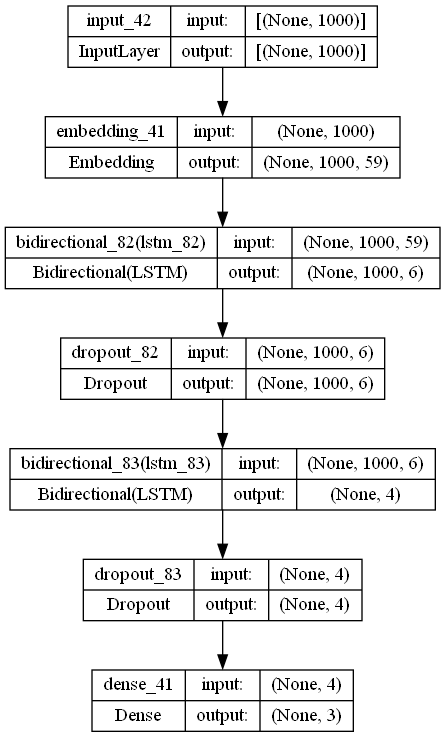

In [83]:
tf.keras.utils.plot_model(best_model,show_shapes=True,to_file='Results/LSTM-Sentiment-Model.png')

In [84]:
sns.set(font_scale=1.4)
def my_conf_matrix(my_y_test,my_y_pred):
  cm = confusion_matrix(my_y_test, my_y_pred)
  cm_norm = np.round(cm/np.sum(cm,axis=1).reshape(-1,1),2)
  sns.heatmap(cm_norm,cmap='Blues',annot=True,
              cbar_kws={'orientation' : 'vertical','label' : 'Color bar'},
              fmt='.2f'
              )
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.savefig('Results/LSTM-confusion_matrix.png', dpi=300, bbox_inches='tight')
  plt.show()

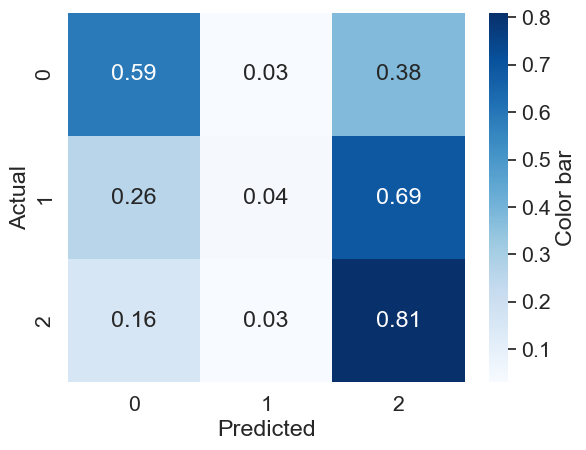

In [85]:
my_conf_matrix(y_true,y_pred)

In [86]:
best_model.save('Results/LSTM-model.hdf5')

Class 0: True Negatives=1223, False Positives=245, False Negatives=276, True Positives=395, MCC=0.4273850753094325
Class 1: True Negatives=2013, False Positives=54, False Negatives=69, True Positives=3, MCC=0.017404492165998906
Class 2: True Negatives=436, False Positives=307, False Negatives=261, True Positives=1135, MCC=0.40619302161642007
Average MCC: 0.28366086303061716


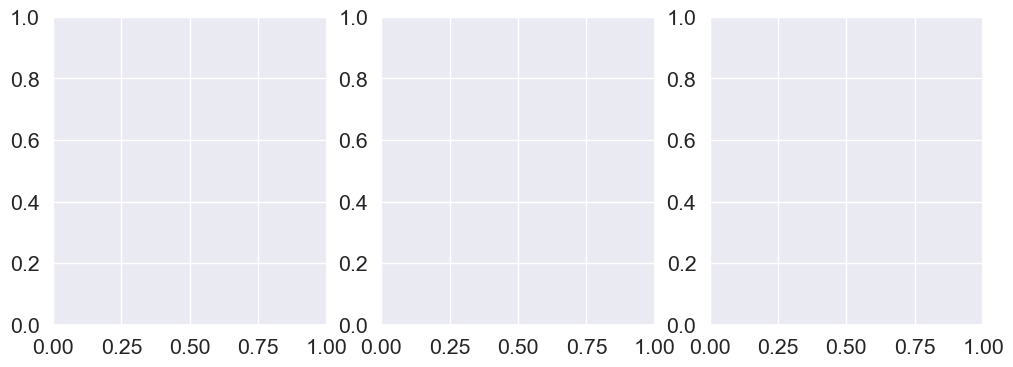

In [87]:
mcm = multilabel_confusion_matrix(y_true, y_pred)

# Plot the confusion matrices
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

mcc_sum = 0
for i in range(3):
    tn, fp, fn, tp = mcm[i].ravel()
    mcc = matthews_corrcoef([1 if x == i else 0 for x in y_true], [1 if x == i else 0 for x in y_pred])
    print(f"Class {i}: True Negatives={tn}, False Positives={fp}, False Negatives={fn}, True Positives={tp}, MCC={mcc}")
    mcc_sum += mcc

mcc_avg = mcc_sum / 3
print(f"Average MCC: {mcc_avg}")